# Overfitting demo

## Create a dataset based on a true sinusoidal relationship
Let's look at a synthetic dataset consisting of 30 points drawn from the sinusoid $y = \sin(4x)$:

In [ ]:
pip install turicreate

     |████████████████████████████████| 91.9MB 35kB/s 
     |████████████████████████████████| 2.1MB 37.0MB/s 
     |████████████████████████████████| 86.3MB 34kB/s 
     |████████████████████████████████| 20.2MB 1.2MB/s 
     |████████████████████████████████| 3.4MB 30.4MB/s 
     |████████████████████████████████| 3.8MB 35.0MB/s 
     |████████████████████████████████| 450kB 46.5MB/s 
ERROR: fastai 0.7.0 has requirement torch<0.4, but you'll have torch 1.4.0 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: google-auth-oauthlib 0.4.0
    Uninstalling google-auth-oauthlib-0.4.0:
      Successfully uninstalled google-auth-oauthlib-0.4.0
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensor

In [ ]:
import turicreate
import math
import random
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

Create random 30 different values for x in interval [0,1)

In [ ]:
random.seed(98103)
n = 30
x = turicreate.SArray([random.random() for i in range(n)]).sort()

Compute y

In [ ]:
y = x.apply(lambda x: math.sin(4*x))

Add random Gaussian noise to y

In [ ]:
random.seed(1)
e = turicreate.SArray([random.gauss(0,1.0/3.0) for i in range(n)])
y = y + e

### Put data into an SFrame to manipulate later

In [ ]:
data = turicreate.SFrame({'X1':x,'Y':y})
data

X1,Y
0.0395789449501,0.587050191026
0.0415680996791,0.648655851372
0.0724319480801,0.307803309485
0.150289044622,0.310748447417
0.161334144502,0.237409625496
0.191956312795,0.705017157224
0.232833917145,0.461716676992
0.259900980166,0.383260507851
0.380145814869,1.06517691429
0.432444723508,1.03184706949


### Create a function to plot the data, since we'll do it many times

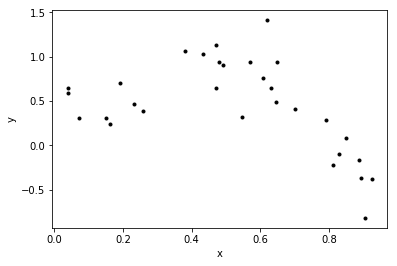

In [ ]:
def plot_data(data):    
    plt.plot(data['X1'],data['Y'],'k.')
    plt.xlabel('x')
    plt.ylabel('y')

plot_data(data)

## Define some useful polynomial regression functions

Define a function to create our features for a polynomial regression model of any degree:

In [ ]:
def polynomial_features(data, deg):
    data_copy=data.copy()
    for i in range(1,deg):
        data_copy['X'+str(i+1)]=data_copy['X'+str(i)]*data_copy['X1']
    return data_copy

# Example: Adding columns for x^2 and x^3
polynomial_features(data, 3)

X1,Y,X2,X3
0.0395789449501,0.587050191026,0.00156649288336,6.20001355952e-05
0.0415680996791,0.648655851372,0.00172790691093,7.18258067099e-05
0.0724319480801,0.307803309485,0.00524638710267,0.000380006038229
0.150289044622,0.310748447417,0.0225867969334,0.0033945481322
0.161334144502,0.237409625496,0.0260287061823,0.00419931904442
0.191956312795,0.705017157224,0.0368472260218,0.00707305764388
0.232833917145,0.461716676992,0.0542116329729,0.0126223068599
0.259900980166,0.383260507851,0.0675485194911,0.0175559264245
0.380145814869,1.06517691429,0.144510840562,0.0549351912429
0.432444723508,1.03184706949,0.18700843889,0.0808708126494


Define a function to fit a polynomial linear regression model of degree "deg" to the data in "data":

In [ ]:
def polynomial_regression(data, deg):
    model = turicreate.linear_regression.create(polynomial_features(data,deg), 
        target='Y', l2_penalty=0., l1_penalty=0.,
        validation_set=None, verbose=False)
    return model

Define function to plot data and predictions made, since we are going to use it many times.

In [ ]:
def plot_poly_predictions(data, model):
    plot_data(data)

    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1
    
    # Create 200 points in the x axis and compute the predicted value for each point
    x_pred = turicreate.SFrame({'X1':[i/200.0 for i in range(200)]})
    y_pred = model.predict(polynomial_features(x_pred,deg))
    
    # plot predictions
    plt.plot(x_pred['X1'], y_pred, 'g-', label='degree ' + str(deg) + ' fit')
    plt.legend(loc='upper left')
    plt.axis([0,1,-1.5,2])

Create a function that prints the polynomial coefficients in a pretty way :)

In [ ]:
def print_coefficients(model):    
    # Get the degree of the polynomial
    deg = len(model.coefficients['value'])-1

    # Get learned parameters as a list
    w = list(model.coefficients['value'])

    # Numpy has a nifty function to print out polynomials in a pretty way
    # (We'll use it, but it needs the parameters in the reverse order)
    print 'Learned polynomial for degree ' + str(deg) + ':'
    w.reverse()
    print numpy.poly1d(w)

## Fit a degree-2 polynomial

Fit our degree-2 polynomial to the data generated above:

In [ ]:
model = polynomial_regression(data, deg=2)

Inspect learned parameters

In [ ]:
print_coefficients(model)

Learned polynomial for degree 2:
        2
-5.129 x + 4.147 x + 0.07471


Form and plot our predictions along a grid of x values:

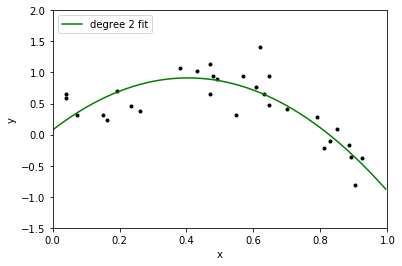

In [ ]:
plot_poly_predictions(data,model)

## Fit a degree-4 polynomial

Learned polynomial for degree 4:
       4         3         2
23.87 x - 53.82 x + 35.23 x - 6.828 x + 0.7755


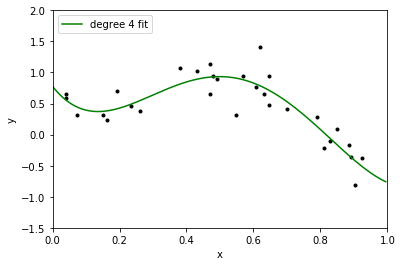

In [ ]:
model = polynomial_regression(data, deg=4)
print_coefficients(model)
plot_poly_predictions(data,model)

## Fit a degree-16 polynomial

In [ ]:
model = polynomial_regression(data, deg=16)
print_coefficients(model)

Learned polynomial for degree 16:
            16             15             14             13
-2.004e+06 x  + 6.675e+06 x  - 3.762e+06 x  - 1.185e+07 x 
              12             11             10             9
 + 1.946e+07 x  - 5.332e+06 x  - 1.012e+07 x  + 9.083e+06 x
              8             7             6             5             4
 - 7.702e+05 x - 2.731e+06 x + 1.844e+06 x - 5.951e+05 x + 1.138e+05 x
              3        2
 - 1.412e+04 x + 1227 x - 70.96 x + 2.171


### Woah!!!!  Those coefficients are *crazy*!  On the order of 10^6.

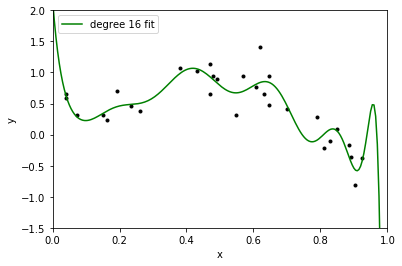

In [ ]:
plot_poly_predictions(data,model)

### Above: Fit looks pretty wild, too.  Here's a clear example of how overfitting is associated with very large magnitude estimated coefficients.

# Ridge Regression

Ridge regression aims to avoid overfitting by adding a cost to the RSS term of standard least squares that depends on the 2-norm of the coefficients $\|w\|$.  The result is penalizing fits with large coefficients.  The strength of this penalty, and thus the fit vs. model complexity balance, is controled by a parameter lambda (here called "L2_penalty").

Define our function to solve the ridge objective for a polynomial regression model of any degree:

In [ ]:
def polynomial_ridge_regression(data, deg, l2_penalty):
    model = turicreate.linear_regression.create(polynomial_features(data,deg), 
                                                target='Y',
                                                l2_penalty=l2_penalty,
                                                validation_set=None,verbose=False)
    return model

## Perform a ridge fit of a degree-16 polynomial using a *very* small penalty strength

In [ ]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=1e-25)
print_coefficients(model)

Learned polynomial for degree 16:
            16             15             14             13
-2.004e+06 x  + 6.675e+06 x  - 3.762e+06 x  - 1.185e+07 x 
              12             11             10             9
 + 1.946e+07 x  - 5.332e+06 x  - 1.012e+07 x  + 9.083e+06 x
              8             7             6             5             4
 - 7.702e+05 x - 2.731e+06 x + 1.844e+06 x - 5.951e+05 x + 1.138e+05 x
              3        2
 - 1.412e+04 x + 1227 x - 70.96 x + 2.171


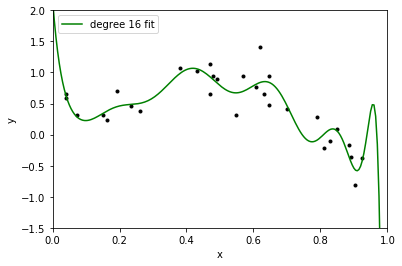

In [ ]:
plot_poly_predictions(data,model)

## Perform a ridge fit of a degree-16 polynomial using a very large penalty strength

In [ ]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=100)
print_coefficients(model)

Learned polynomial for degree 16:
        16          15          14          13          12         11
-0.301 x  - 0.2802 x  - 0.2604 x  - 0.2413 x  - 0.2229 x  - 0.205 x 
           10          9          8          7          6           5
 - 0.1874 x  - 0.1699 x - 0.1524 x - 0.1344 x - 0.1156 x - 0.09534 x
            4           3           2
 - 0.07304 x - 0.04842 x - 0.02284 x - 0.002257 x + 0.6416


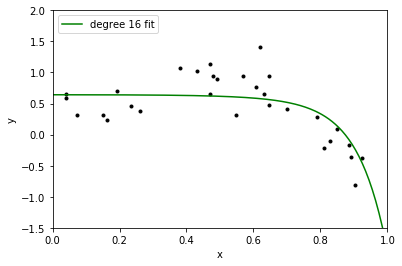

In [ ]:
plot_poly_predictions(data,model)

## Let's look at fits for a sequence of increasing lambda values

lambda = 1.00e-25
Learned polynomial for degree 16:
            16             15             14             13
-2.004e+06 x  + 6.675e+06 x  - 3.762e+06 x  - 1.185e+07 x 
              12             11             10             9
 + 1.946e+07 x  - 5.332e+06 x  - 1.012e+07 x  + 9.083e+06 x
              8             7             6             5             4
 - 7.702e+05 x - 2.731e+06 x + 1.844e+06 x - 5.951e+05 x + 1.138e+05 x
              3        2
 - 1.412e+04 x + 1227 x - 70.96 x + 2.171


lambda = 1.00e-10
Learned polynomial for degree 16:
           16             15             14            13
4.975e+04 x  - 7.821e+04 x  - 2.265e+04 x  + 3.95e+04 x 
              12        11             10             9             8
 + 4.365e+04 x  + 3077 x  - 3.332e+04 x  - 2.786e+04 x + 1.033e+04 x
              7        6             5             4        3         2
 + 2.962e+04 x - 1441 x - 2.597e+04 x + 1.839e+04 x - 5596 x + 866.1 x - 65.19 x + 2.159


lambda = 1.00e-06
Learned p

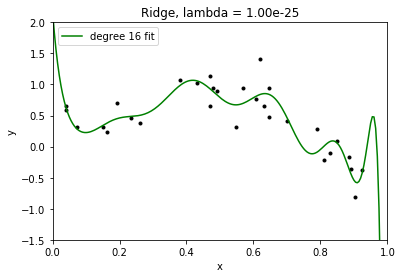

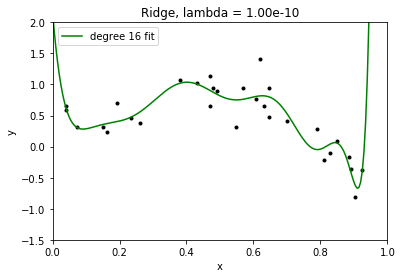

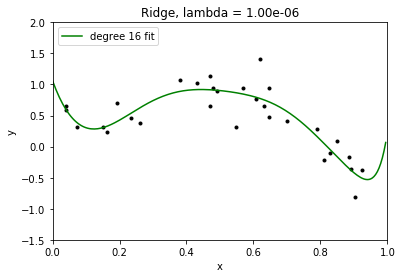

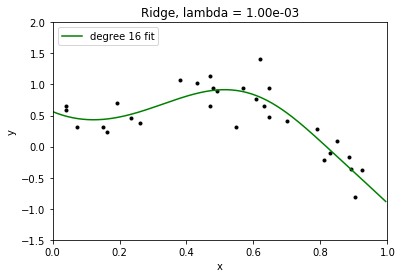

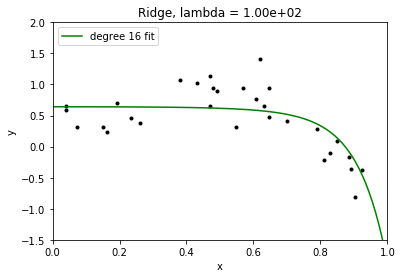

In [ ]:
for l2_penalty in [1e-25, 1e-10, 1e-6, 1e-3, 1e2]:
    model = polynomial_ridge_regression(data, deg=16, l2_penalty=l2_penalty)
    print 'lambda = %.2e' % l2_penalty
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('Ridge, lambda = %.2e' % l2_penalty)

## Perform a ridge fit of a degree-16 polynomial using a "good" penalty strength

We will learn about cross validation later in this course as a way to select a good value of the tuning parameter (penalty strength) lambda.  Here, we consider "leave one out" (LOO) cross validation, which one can show approximates average mean square error (MSE).  As a result, choosing lambda to minimize the LOO error is equivalent to choosing lambda to minimize an approximation to average MSE.

_Note:_ For applying cross-validation, we will import a package called `turicreate_cross_validation`.

# The next set of code didnt run. Error:



In [ ]:
# The next set of code didnt run. 
# ImportError: No module named turicreate_cross_validation.cross_validation

# ---------------------------------------------------------------------------
# NOTE: If your import is failing due to a missing package, you can
# manually install dependencies using either !pip or !apt.

# To view examples of installing some common dependencies, click the
# "Open Examples" button below.

# So I clicked "Open Examples" and then installing these below libraries and will
# try to run the next set of codes again

!pip install matplotlib-venn

!apt-get -qq install -y libfluidsynth1

# https://pypi.python.org/pypi/libarchive    # Install 7zip reader libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive

# https://pypi.python.org/pypi/pydot    # Install GraphViz & PyDot
!apt-get -qq install -y graphviz && pip install pydot
import pydot

!pip install cartopy
import cartopy

### even after doing teh above the next set of codes didnt run. So will google about teh error to find the soution

Selecting previously unselected package libfluidsynth1:amd64.
(Reading database ... 148486 files and directories currently installed.)
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 148491 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.2.2-3.1ubuntu0.7_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Setting up libarchive-dev:amd64 (3.2.2-3.1ubuntu0.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
  Created wheel for libarchive: filename=libarchive-0.4.7-cp27-none-any.whl size=31633 sha256=e808743f55bae71ad5f9cd3f8d97f206fc68815ef5ee382a321b710827b8e3de
  Stored in d

In [ ]:
# so under the discussion for I searched for "No module named turicreate_cross_validation.cross_validation"
# and there were couple of them asking the same questions and some of them have answers as well.
# Im going to try the code that I feel is the leaset complex first

#pip install -e git+https://github.com/Kagandi/turicreate-cross-validation.git #egg=turicreate_cross_validation
# didnt work

#### Copy Pasted teh discussion forum ####
#### "Note: For applying cross-validation, we will import a package called turicreate_cross_validation. To install it, please run this command on your terminal:
#### pip install -e git+https://github.com/Kagandi/turicreate-cross-validation.git#egg=turicreate_cross_validation
#### You can find the documentation on this package here: https://github.com/Kagandi/turicreate-cross-validation" 
#### I did not bother to install the full package; one file is sufficient. Download it into the directory where your notebook is running with 
#### !wget https://github.com/Kagandi/turicreate-cross-validation/raw/master/turicreate_cross_validation/cross_validation.py
####  then modify the import in the notebook like this:
#### #import turicreate_cross_validation.cross_validation as tcv
#### import cross_validation as tcv


!wget https://github.com/Kagandi/turicreate-cross-validation/raw/master/turicreate_cross_validation/cross_validation.py

--2021-08-22 00:18:56--  https://github.com/Kagandi/turicreate-cross-validation/raw/master/turicreate_cross_validation/cross_validation.py
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Kagandi/turicreate-cross-validation/master/turicreate_cross_validation/cross_validation.py [following]
--2021-08-22 00:18:56--  https://raw.githubusercontent.com/Kagandi/turicreate-cross-validation/master/turicreate_cross_validation/cross_validation.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8286 (8.1K) [text/plain]
Saving to: ‘cross_validation.py’

cross_validation.py 100%[===================>]   8.

In [ ]:
# import turicreate_cross_validation.cross_validation as tcv
# hashed out the above code and using the below as someone suggested to do after the last line of teh previous code that seemed to work.

import cross_validation as tcv

# LOO cross validation -- return the average MSE
def loo(data, deg, l2_penalty_values):
    # Create polynomial features
    data = polynomial_features(data, deg)
    
    # Create as many folds for cross validatation as number of data points
    num_folds = len(data)
    shuffled_data = tcv.shuffle_sframe(data, 98103)
    folds_iterator = tcv.KFold(shuffled_data, num_folds)
    folds = [f for f in folds_iterator]
    
    # for each value of l2_penalty, fit a model for each fold and compute average MSE
    l2_penalty_mse = []
    min_mse = None
    best_l2_penalty = None
    for l2_penalty in l2_penalty_values:
        next_mse = 0.0
        for train_set, validation_set in folds:
            # train model
            model = turicreate.linear_regression.create(train_set,target='Y', 
                                                        l2_penalty=l2_penalty,
                                                        validation_set=None,verbose=False)
            
            # predict on validation set 
            y_test_predicted = model.predict(validation_set)
            # compute squared error
            next_mse += ((y_test_predicted-validation_set['Y'])**2).sum()
            #print "   Error so far:", next_mse
        # save squared error in list of MSE for each l2_penalty
        next_mse = next_mse/num_folds
        l2_penalty_mse.append(next_mse)
        if min_mse is None or next_mse < min_mse:
            min_mse = next_mse
            best_l2_penalty = l2_penalty
            
    return l2_penalty_mse,best_l2_penalty

Run LOO cross validation for "num" values of lambda, on a log scale

In [ ]:
l2_penalty_values = numpy.logspace(-4, 10, num=10)
l2_penalty_mse,best_l2_penalty = loo(data, 16, l2_penalty_values)

Plot results of estimating LOO for each value of lambda

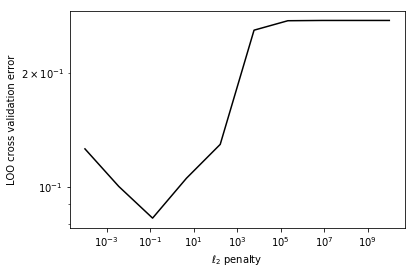

In [ ]:
plt.plot(l2_penalty_values,l2_penalty_mse,'k-')
plt.xlabel('$\ell_2$ penalty')
plt.ylabel('LOO cross validation error')
plt.xscale('log')
plt.yscale('log')

Find the value of lambda, $\lambda_{\mathrm{CV}}$, that minimizes the LOO cross validation error, and plot resulting fit

In [ ]:
best_l2_penalty

0.1291549665014884

In [ ]:
model = polynomial_ridge_regression(data, deg=16, l2_penalty=best_l2_penalty)
print_coefficients(model)

Learned polynomial for degree 16:
       16         15          14          13          12           11
1.345 x  + 1.141 x  + 0.9069 x  + 0.6447 x  + 0.3569 x  + 0.04947 x 
           10          9          8         7         6         5
 - 0.2683 x  - 0.5821 x - 0.8701 x - 1.099 x - 1.216 x - 1.145 x
           4           3          2
 - 0.7837 x - 0.07406 x + 0.7614 x + 0.7703 x + 0.3918


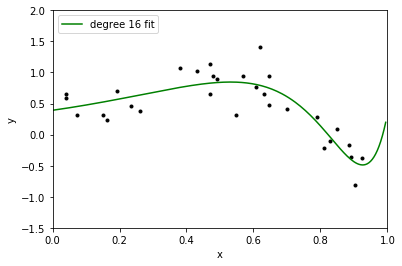

In [ ]:
plot_poly_predictions(data,model)

# Lasso Regression

Lasso regression jointly shrinks coefficients to avoid overfitting, and implicitly performs feature selection by setting some coefficients exactly to 0 for sufficiently large penalty strength lambda (here called "L1_penalty").  In particular, lasso takes the RSS term of standard least squares and adds a 1-norm cost of the coefficients $\|w\|$.

Define our function to solve the lasso objective for a polynomial regression model of any degree:

In [ ]:
def polynomial_lasso_regression(data, deg, l1_penalty):
    model = turicreate.linear_regression.create(polynomial_features(data,deg), 
                                                target='Y', l2_penalty=0.,
                                                l1_penalty=l1_penalty,
                                                validation_set=None, 
                                                solver='fista', verbose=False,
                                                max_iterations=3000, convergence_threshold=1e-10)
    return model

## Explore the lasso solution as a function of a few different penalty strengths

We refer to lambda in the lasso case below as "l1_penalty"

l1_penalty = 1.000000e-04
number of nonzeros = 17
Learned polynomial for degree 16:
       16        15         14         13         12         11
29.02 x  + 1.35 x  - 12.72 x  - 16.93 x  - 13.82 x  - 6.698 x 
          10         9         8         7         6         5
 + 1.407 x  + 8.939 x + 12.88 x + 11.44 x + 3.759 x - 8.062 x
          4         3         2
 - 16.28 x - 7.682 x + 17.86 x - 4.384 x + 0.685


l1_penalty = 1.000000e-02
number of nonzeros = 14
Learned polynomial for degree 16:
       16            15           11          10         9          8
-1.18 x  - 0.001315 x  + 0.08748 x  + 0.7389 x  + 3.829 x + 0.4761 x
           7            6          5         4             3         2
 + 0.1283 x + 0.001661 x - 0.6151 x - 10.11 x - 0.0003721 x + 6.686 x - 1.28 x + 0.5056


l1_penalty = 1.000000e-01
number of nonzeros = 5
Learned polynomial for degree 16:
       16          6        5
2.153 x  - 0.7958 x - 3.14 x + 1.224 x + 0.3459


l1_penalty = 1.000000e+01
number o

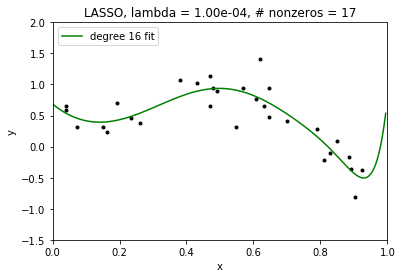

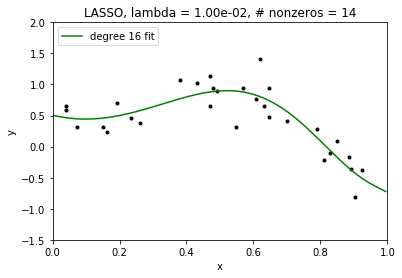

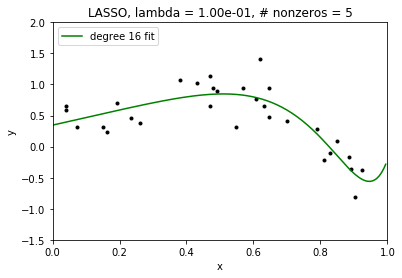

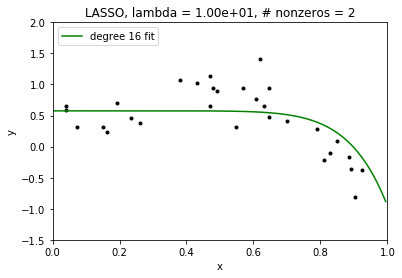

In [ ]:
for l1_penalty in [0.0001, 0.01, 0.1, 10]:
    model = polynomial_lasso_regression(data, deg=16, l1_penalty=l1_penalty)
    print 'l1_penalty = %e' % l1_penalty
    print 'number of nonzeros = %d' % (model.coefficients['value']).nnz()
    print_coefficients(model)
    print '\n'
    plt.figure()
    plot_poly_predictions(data,model)
    plt.title('LASSO, lambda = %.2e, # nonzeros = %d' % (l1_penalty, (model.coefficients['value']).nnz()))

Above: We see that as lambda increases, we get sparser and sparser solutions.  However, even for our non-sparse case for lambda=0.0001, the fit of our high-order polynomial is not too wild.  This is because, like in ridge, coefficients included in the lasso solution are shrunk relative to those of the least squares (unregularized) solution.  This leads to better behavior even without sparsity.  Of course, as lambda goes to 0, the amount of this shrinkage decreases and the lasso solution approaches the (wild) least squares solution.